# Figure 2
## Global Period Maps

Notes:

Put the sequential 30 year period maps of ALL and AER into the supplement

``Done.``

Can we calculate B as a percent of A to show how much larger the HWF would have been without AA changes since 1920? Just to be able to say verbally and maybe put in the supplement. This is mostly to be able to cite those percentages in the text -- as in "aerosol changes since 1920 reduced HWF by 50% over the ETCCDI period. Same can we calculate D as percent of C.

``The desired ratios are shown figures 2.1 and 2.2``

Can we calculate correlation coefficient between B and D to make the point of how different the spatial pattern is in the near-future compared to a widely used baseline period.

``See analysis below figure 2.1``

In [24]:
import xarray
from distributed import Client
import numpy as np
import cftime
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import pearsonr
import cartopy.crs as ccrs


def sig_testing(all_ds, xaer_ds):
    all_array = all_ds.values
    xaer_array = xaer_ds.values

    def welch_t_test(all_pt, xaer_pt, lat, lon):
        t_val, p_val = ttest_ind(all_pt, xaer_pt, equal_var=False)
        return ((lat, lon), p_val)

    results = []
    for lati, lat in enumerate(all_ds.lat.values):
        for loni, lon in enumerate(all_ds.lon.values):
            all_pt = all_array[0:all_ds["member"].size, 0:all_ds["year"].size, lati, loni].flatten()
            xaer_pt = xaer_array[0:xaer_ds["member"].size, 0:xaer_ds["year"].size, lati, loni].flatten()
            t_value, p_value = ttest_ind(all_pt, xaer_pt, equal_var=False)
            results.append(((lat, lon), p_value))

    sig_results = (all_ds.mean(dim="member").mean(dim="year").load() * 0).rename("p-value")
    for (lat, lon), p_value in results:
        sig_results.loc[dict(lat=lat, lon=lon)] = p_value
    return sig_results

client = Client('localhost:8786')
client

<Client: 'tcp://146.6.192.149:8786' processes=10 threads=80>

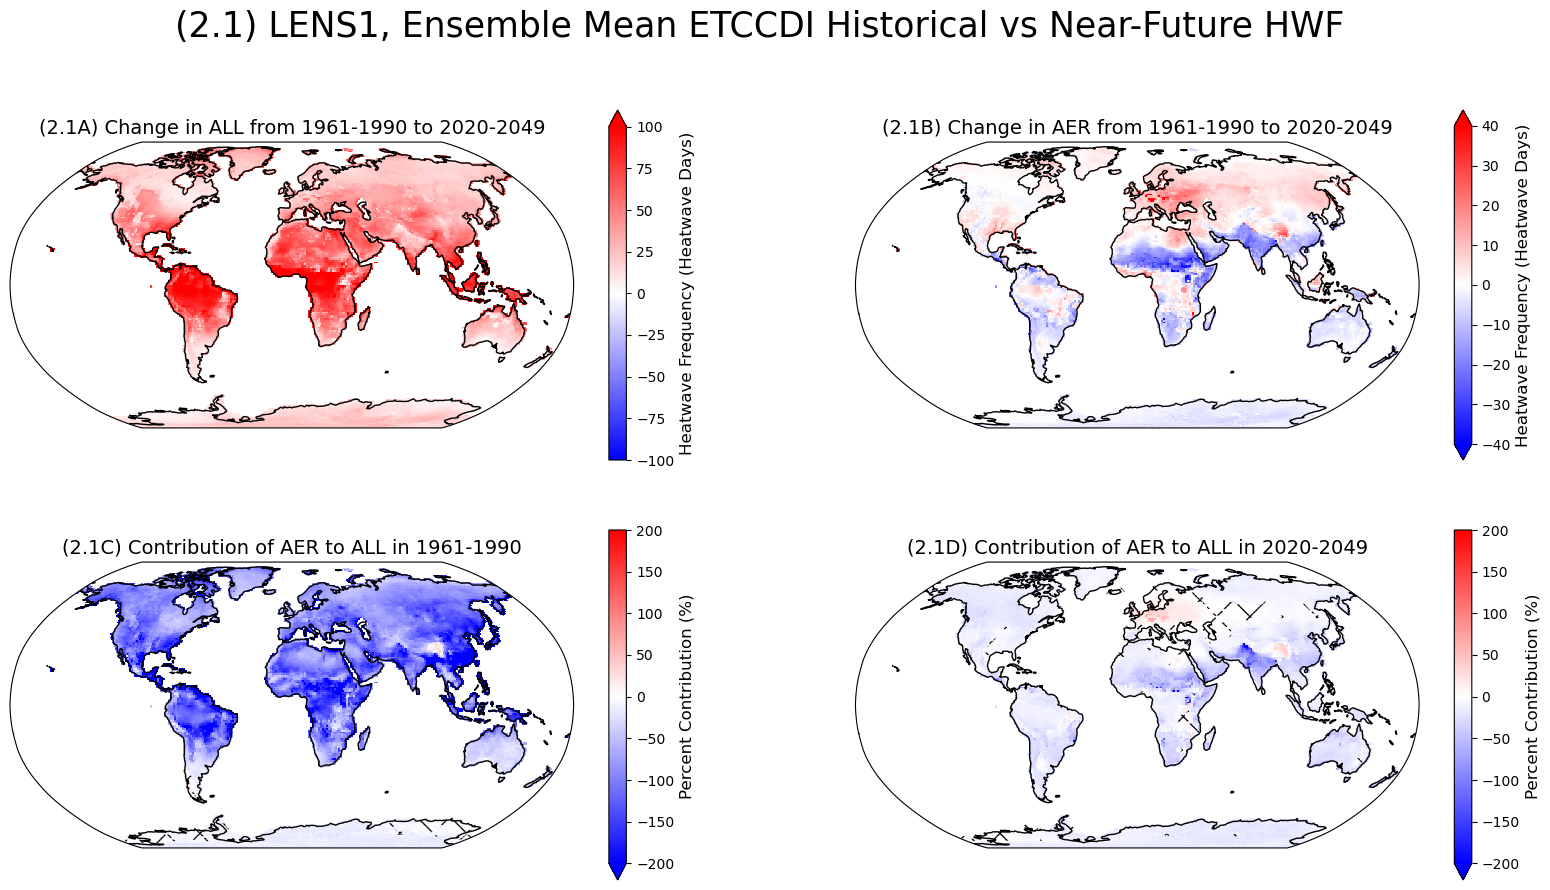

In [23]:
HW_DIR = "/projects/dgs/persad_research/SIMULATION_DATA/ZARR/LENS1/HEAT_OUTPUTS/"

land_mask_path = "/projects/dgs/persad_research/SIMULATION_DATA/DATA/LENS1/CESM1/all/001/day/LANDFRAC/b.e11.B1850C5CN.f09_g16.005.cam.h0.LANDFRAC.200001-209912.nc"
land_mask = xarray.open_dataset(land_mask_path)["LANDFRAC"].mean(dim="time")

hw_mn_all_path = f"{HW_DIR}CESM1_LE_all_TREFHTMN_HW_METRICS.zarr"
hw_mn_xaer_path = f"{HW_DIR}CESM1_LE_xaer_TREFHTMN_HW_METRICS.zarr"

hw_mn_all = xarray.open_zarr(hw_mn_all_path)["HWF"]
hw_mn_xaer = xarray.open_zarr(hw_mn_xaer_path)["HWF"]

fut_start, fut_end = 2020, 2049
past_start, past_end = 1961, 1990

hw_mn_all_fut = hw_mn_all.sel(percentile=0.9).where(land_mask > 0).sel(year=slice(fut_start, fut_end)).compute()
hw_mn_xaer_fut = hw_mn_xaer.sel(percentile=0.9).where(land_mask > 0).sel(year=slice(fut_start, fut_end)).compute()
hw_mn_all_past = hw_mn_all.sel(percentile=0.9).where(land_mask > 0).sel(year=slice(past_start, past_end)).compute()
hw_mn_xaer_past = hw_mn_xaer.sel(percentile=0.9).where(land_mask > 0).sel(year=slice(past_start, past_end)).compute()

hw_mn_sig_fut = sig_testing(hw_mn_all_fut, hw_mn_xaer_fut)
hw_mn_sig_past = sig_testing(hw_mn_all_past, hw_mn_xaer_past)

hw_mn_all_fut_map = hw_mn_all_fut.mean(dim=["member", "year"])
hw_mn_xaer_fut_map = hw_mn_xaer_fut.mean(dim=["member", "year"])
hw_mn_all_past_map = hw_mn_all_past.mean(dim=["member", "year"])
hw_mn_xaer_past_map = hw_mn_xaer_past.mean(dim=["member", "year"])

proj = ccrs.Robinson()
transform = ccrs.PlateCarree()
cmap = "bwr"
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 10), facecolor='w', subplot_kw=dict(projection=proj))


cb1 = (hw_mn_all_fut_map - hw_mn_all_past_map).plot(ax=ax1, transform=transform, cmap=cmap, vmax=100, vmin=-100)
cb2 = ((hw_mn_all_fut_map - hw_mn_xaer_fut_map) - (hw_mn_all_past_map - hw_mn_xaer_past_map)).plot(ax=ax2, transform=transform, cmap=cmap, vmax=40, vmin=-40)
cb3 = (100*((hw_mn_all_past_map - hw_mn_xaer_past_map) / hw_mn_all_past_map)).plot(ax=ax3, transform=transform, cmap=cmap, vmin=-200, vmax=200)
cb4 = (100*((hw_mn_all_fut_map - hw_mn_xaer_fut_map) / hw_mn_all_fut_map)).plot(ax=ax4, transform=transform, cmap=cmap, vmin=-200, vmax=200)

fz = 12
cb1.colorbar.set_label("Heatwave Frequency (Heatwave Days)", fontsize=fz)
cb2.colorbar.set_label("Heatwave Frequency (Heatwave Days)", fontsize=fz)
cb3.colorbar.set_label("Percent Contribution (%)", fontsize=fz)
cb4.colorbar.set_label("Percent Contribution (%)", fontsize=fz)

X, Y = np.meshgrid(hw_mn_sig_fut.lon, hw_mn_sig_fut.lat)
ax3.hexbin(X.reshape(-1), Y.reshape(-1), hw_mn_sig_past.where(hw_mn_sig_past > 0.5).data.reshape(-1), hatch='x', alpha=0, transform=ccrs.PlateCarree())
ax4.hexbin(X.reshape(-1), Y.reshape(-1), hw_mn_sig_fut.where(hw_mn_sig_fut > 0.5).data.reshape(-1), hatch='x', alpha=0, transform=ccrs.PlateCarree())

fz = 14
ax1.set_title(f"(2.1A) Change in ALL from {past_start}-{past_end} to {fut_start}-{fut_end}", fontsize=fz)
ax2.set_title(f"(2.1B) Change in AER from {past_start}-{past_end} to {fut_start}-{fut_end}", fontsize=fz)
ax3.set_title(f"(2.1C) Contribution of AER to ALL in {past_start}-{past_end}", fontsize=fz)
ax4.set_title(f"(2.1D) Contribution of AER to ALL in {fut_start}-{fut_end}", fontsize=fz)

ax1.coastlines()
ax2.coastlines()
ax3.coastlines()
ax4.coastlines()

f.suptitle("(2.1) LENS1, Ensemble Mean ETCCDI Historical vs Near-Future HWF", fontsize=25)
f.show()

In [39]:
future_vals = hw_mn_all_fut.mean(dim="year").values.flatten()
past_vals = hw_mn_all_past.mean(dim="year").values.flatten()
future_vals = future_vals[~np.isnan(future_vals)]
past_vals = past_vals[~np.isnan(past_vals)]

print(f"Correlation between ETCCDI and Near-Present ALL:\n  {pearsonr(future_vals, past_vals)}\n")

future_vals = hw_mn_xaer_fut.values.flatten()
past_vals = hw_mn_xaer_past.values.flatten()
future_vals = future_vals[~np.isnan(future_vals)]
past_vals = past_vals[~np.isnan(past_vals)]

print(f"Correlation between ETCCDI and Near-Present XAER:\n  {pearsonr(future_vals, past_vals)}\n")

Correlation between ETCCDI and Near-Present ALL:
  PearsonRResult(statistic=0.2792471632906309, pvalue=0.0)

Correlation between ETCCDI and Near-Present XAER:
  PearsonRResult(statistic=0.35946763604513166, pvalue=0.0)



Note for the correlation analysis above, we average by year to remove inter-annual variability. This will compare the sptial patterns of heatwave as opposed to the temporal patterns that occur during the two time periods. I am skeptical that leaving the time component will apprporiately account for temporal patterns because the two periods likely have different phases. Natural variability is perserved by not averaging the ensemble. I think, unlike the time dimension, this *is* appropriate because both periods are aligned along the same perturbation set and thus share the same natural variability.

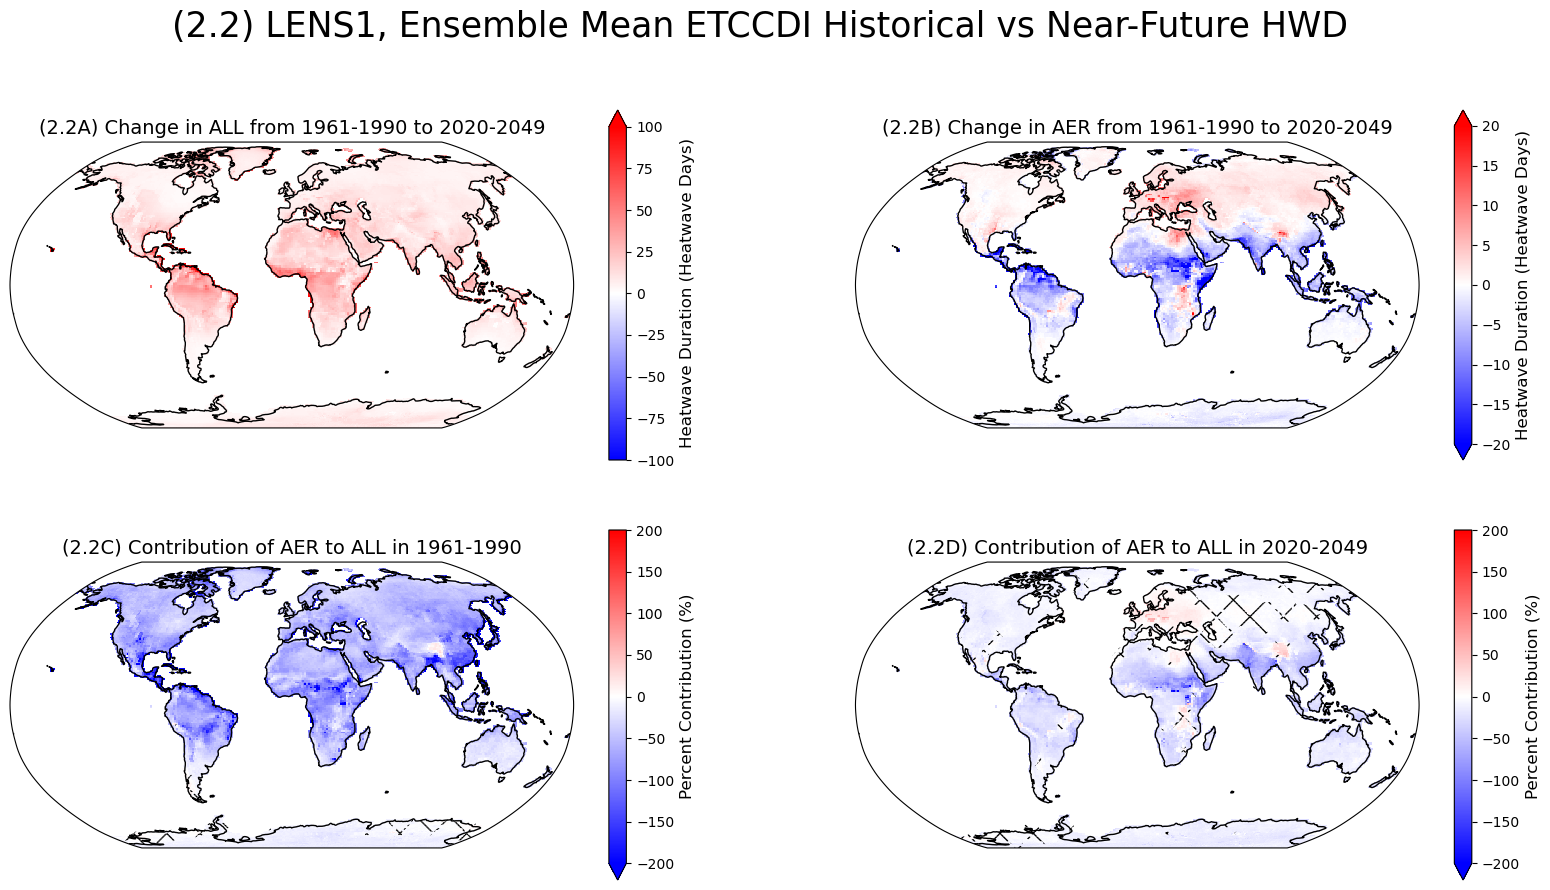

In [19]:
HW_DIR = "/projects/dgs/persad_research/SIMULATION_DATA/ZARR/LENS1/HEAT_OUTPUTS/"

land_mask_path = "/projects/dgs/persad_research/SIMULATION_DATA/DATA/LENS1/CESM1/all/001/day/LANDFRAC/b.e11.B1850C5CN.f09_g16.005.cam.h0.LANDFRAC.200001-209912.nc"
land_mask = xarray.open_dataset(land_mask_path)["LANDFRAC"].mean(dim="time")

hw_mn_all_path = f"{HW_DIR}CESM1_LE_all_TREFHTMN_HW_METRICS.zarr"
hw_mn_xaer_path = f"{HW_DIR}CESM1_LE_xaer_TREFHTMN_HW_METRICS.zarr"

hw_mn_all = xarray.open_zarr(hw_mn_all_path)["HWD"]
hw_mn_xaer = xarray.open_zarr(hw_mn_xaer_path)["HWD"]

fut_start, fut_end = 2020, 2049
past_start, past_end = 1961, 1990

hw_mn_all_fut = hw_mn_all.sel(percentile=0.9).where(land_mask > 0).sel(year=slice(fut_start, fut_end)).compute()
hw_mn_xaer_fut = hw_mn_xaer.sel(percentile=0.9).where(land_mask > 0).sel(year=slice(fut_start, fut_end)).compute()
hw_mn_all_past = hw_mn_all.sel(percentile=0.9).where(land_mask > 0).sel(year=slice(past_start, past_end)).compute()
hw_mn_xaer_past = hw_mn_xaer.sel(percentile=0.9).where(land_mask > 0).sel(year=slice(past_start, past_end)).compute()

hw_mn_sig_fut = sig_testing(hw_mn_all_fut, hw_mn_xaer_fut)
hw_mn_sig_past = sig_testing(hw_mn_all_past, hw_mn_xaer_past)

hw_mn_all_fut_map = hw_mn_all_fut.mean(dim=["member", "year"])
hw_mn_xaer_fut_map = hw_mn_xaer_fut.mean(dim=["member", "year"])
hw_mn_all_past_map = hw_mn_all_past.mean(dim=["member", "year"])
hw_mn_xaer_past_map = hw_mn_xaer_past.mean(dim=["member", "year"])

proj = ccrs.Robinson()
transform = ccrs.PlateCarree()
cmap = "bwr"
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 10), facecolor='w', subplot_kw=dict(projection=proj))


cb1 = (hw_mn_all_fut_map - hw_mn_all_past_map).plot(ax=ax1, transform=transform, cmap=cmap, vmax=100, vmin=-100)
cb2 = ((hw_mn_all_fut_map - hw_mn_xaer_fut_map) - (hw_mn_all_past_map - hw_mn_xaer_past_map)).plot(ax=ax2, transform=transform, cmap=cmap, vmax=20, vmin=-20)
cb3 = (100*((hw_mn_all_past_map - hw_mn_xaer_past_map) / hw_mn_all_past_map)).plot(ax=ax3, transform=transform, cmap=cmap, vmin=-200, vmax=200)
cb4 = (100*((hw_mn_all_fut_map - hw_mn_xaer_fut_map) / hw_mn_all_fut_map)).plot(ax=ax4, transform=transform, cmap=cmap, vmin=-200, vmax=200)

fz = 12
cb1.colorbar.set_label("Heatwave Duration (Heatwave Days)", fontsize=fz)
cb2.colorbar.set_label("Heatwave Duration (Heatwave Days)", fontsize=fz)
cb3.colorbar.set_label("Percent Contribution (%)", fontsize=fz)
cb4.colorbar.set_label("Percent Contribution (%)", fontsize=fz)

X, Y = np.meshgrid(hw_mn_sig_fut.lon, hw_mn_sig_fut.lat)
ax3.hexbin(X.reshape(-1), Y.reshape(-1), hw_mn_sig_past.where(hw_mn_sig_past > 0.5).data.reshape(-1), hatch='x', alpha=0, transform=ccrs.PlateCarree())
ax4.hexbin(X.reshape(-1), Y.reshape(-1), hw_mn_sig_fut.where(hw_mn_sig_fut > 0.5).data.reshape(-1), hatch='x', alpha=0, transform=ccrs.PlateCarree())

fz = 14
ax1.set_title(f"(2.2A) Change in ALL from {past_start}-{past_end} to {fut_start}-{fut_end}", fontsize=fz)
ax2.set_title(f"(2.2B) Change in AER from {past_start}-{past_end} to {fut_start}-{fut_end}", fontsize=fz)
ax3.set_title(f"(2.2C) Contribution of AER to ALL in {past_start}-{past_end}", fontsize=fz)
ax4.set_title(f"(2.2D) Contribution of AER to ALL in {fut_start}-{fut_end}", fontsize=fz)

ax1.coastlines()
ax2.coastlines()
ax3.coastlines()
ax4.coastlines()

f.suptitle("(2.2) LENS1, Ensemble Mean ETCCDI Historical vs Near-Future HWD", fontsize=25)
f.show()

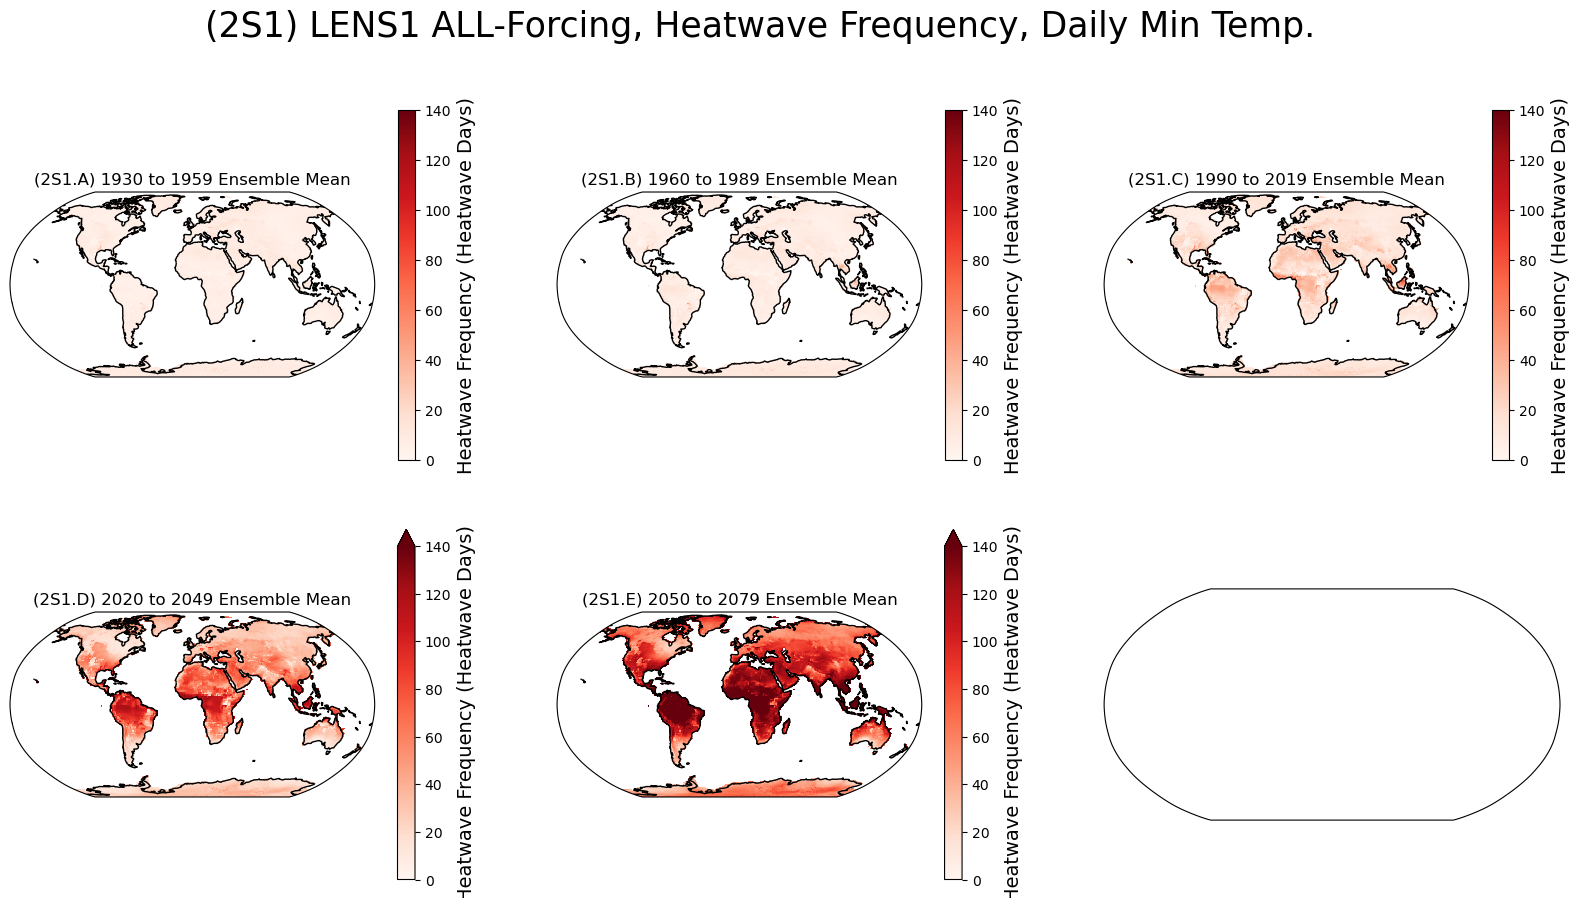

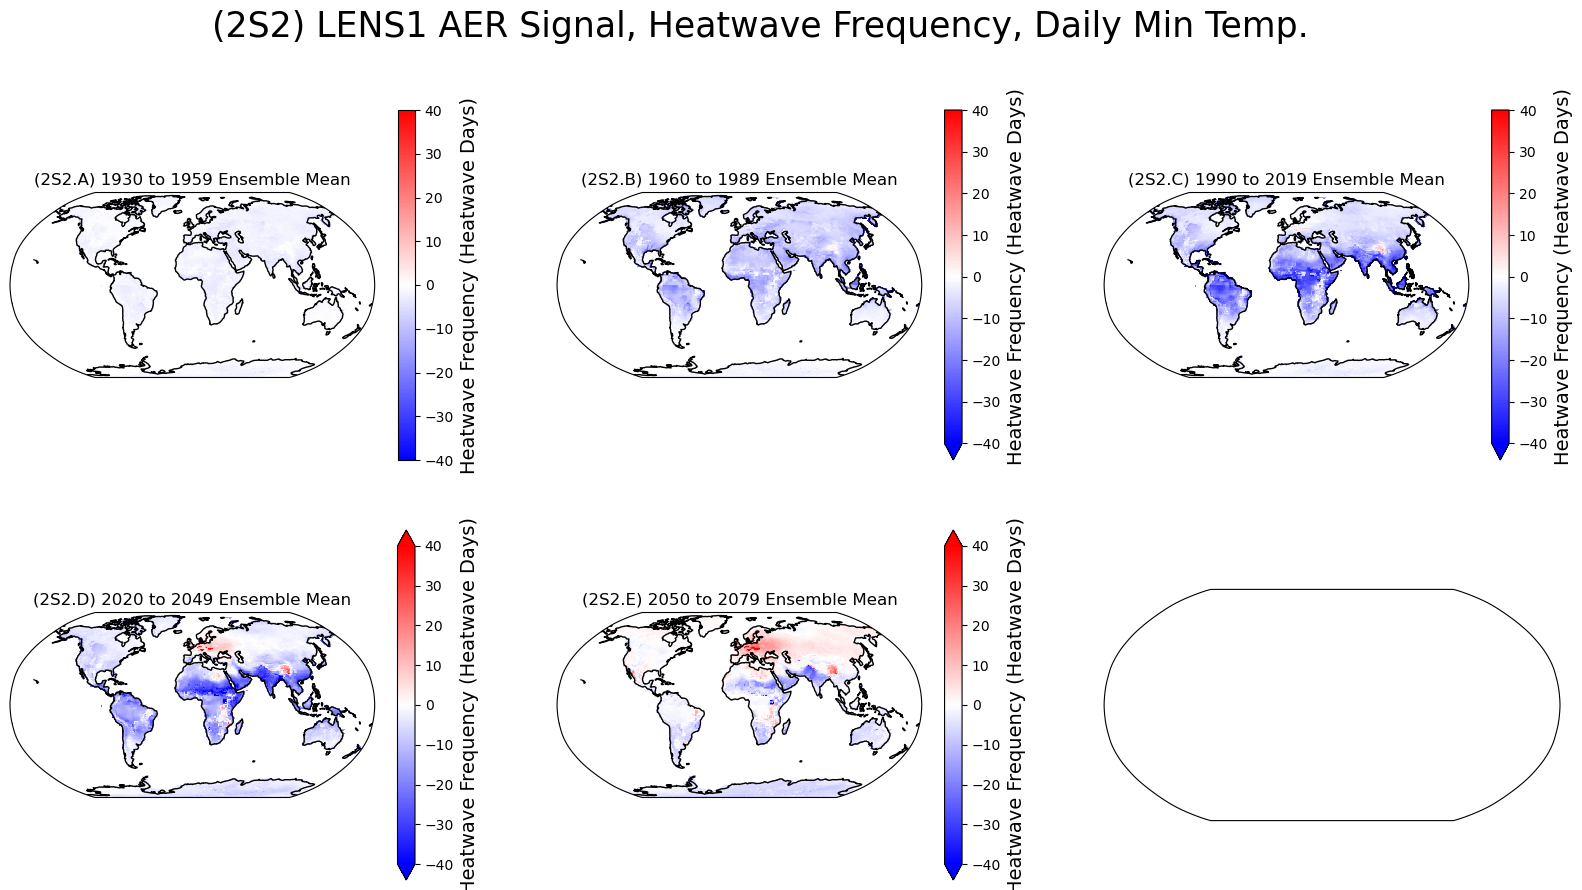

In [21]:
hw_mn_all = xarray.open_zarr(hw_mn_all_path)["HWF"]
hw_mn_xaer = xarray.open_zarr(hw_mn_xaer_path)["HWF"]

proj = ccrs.Robinson()
transform = ccrs.PlateCarree()

f1, axes1 = plt.subplots(2, 3, figsize=(20, 10), facecolor='w', subplot_kw=dict(projection=proj))
f2, axes2 = plt.subplots(2, 3, figsize=(20, 10), facecolor='w', subplot_kw=dict(projection=proj))

decades = [
    (1930, 1959),
    (1960, 1989),
    (1990, 2019),
    (2020, 2049),
    (2050, 2079)
]
label = ["A", "B", "C", "D", "E"]
for index, (start, end) in enumerate(decades):
    all_slice = hw_mn_all.sel(percentile=0.9).where(land_mask > 0).sel(year=slice(start, end)).mean(dim=["member", "year"]).compute()
    xaer_slice = hw_mn_xaer.sel(percentile=0.9).where(land_mask > 0).sel(year=slice(start, end)).mean(dim=["member", "year"]).compute()
    aer = all_slice - xaer_slice

    ax1 = axes1.flatten()[index]
    cb1 = all_slice.plot(ax=ax1, transform=transform, cmap="Reds", vmin=0, vmax=140)
    cb1.colorbar.set_label("Heatwave Frequency (Heatwave Days)", fontsize=fz)
    ax1.coastlines()
    ax1.set_title(f"(2S1.{label[index]}) {start} to {end} Ensemble Mean")

    ax2 = axes2.flatten()[index]
    cb2 = aer.plot(ax=ax2, transform=transform, cmap="bwr", vmin=-40, vmax=40)
    cb2.colorbar.set_label("Heatwave Frequency (Heatwave Days)", fontsize=fz)
    ax2.coastlines()
    ax2.set_title(f"(2S2.{label[index]}) {start} to {end} Ensemble Mean")


f1.suptitle("(2S1) LENS1 ALL-Forcing, Heatwave Frequency, Daily Min Temp.", fontsize=25)
f2.suptitle("(2S2) LENS1 AER Signal, Heatwave Frequency, Daily Min Temp.", fontsize=25)

f1.show()
f2.show()

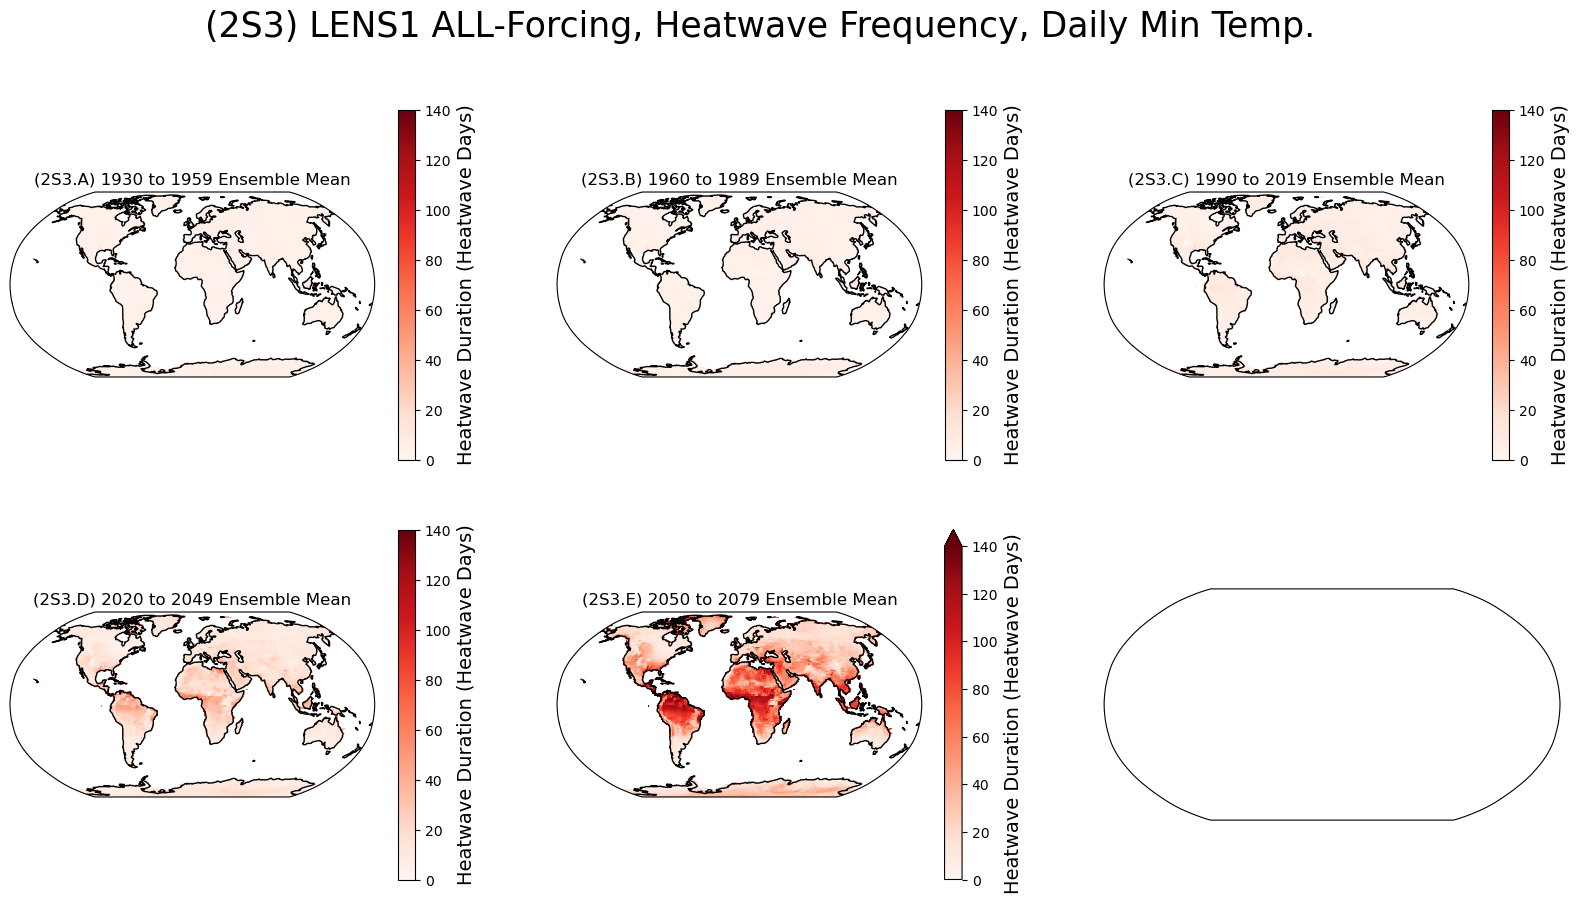

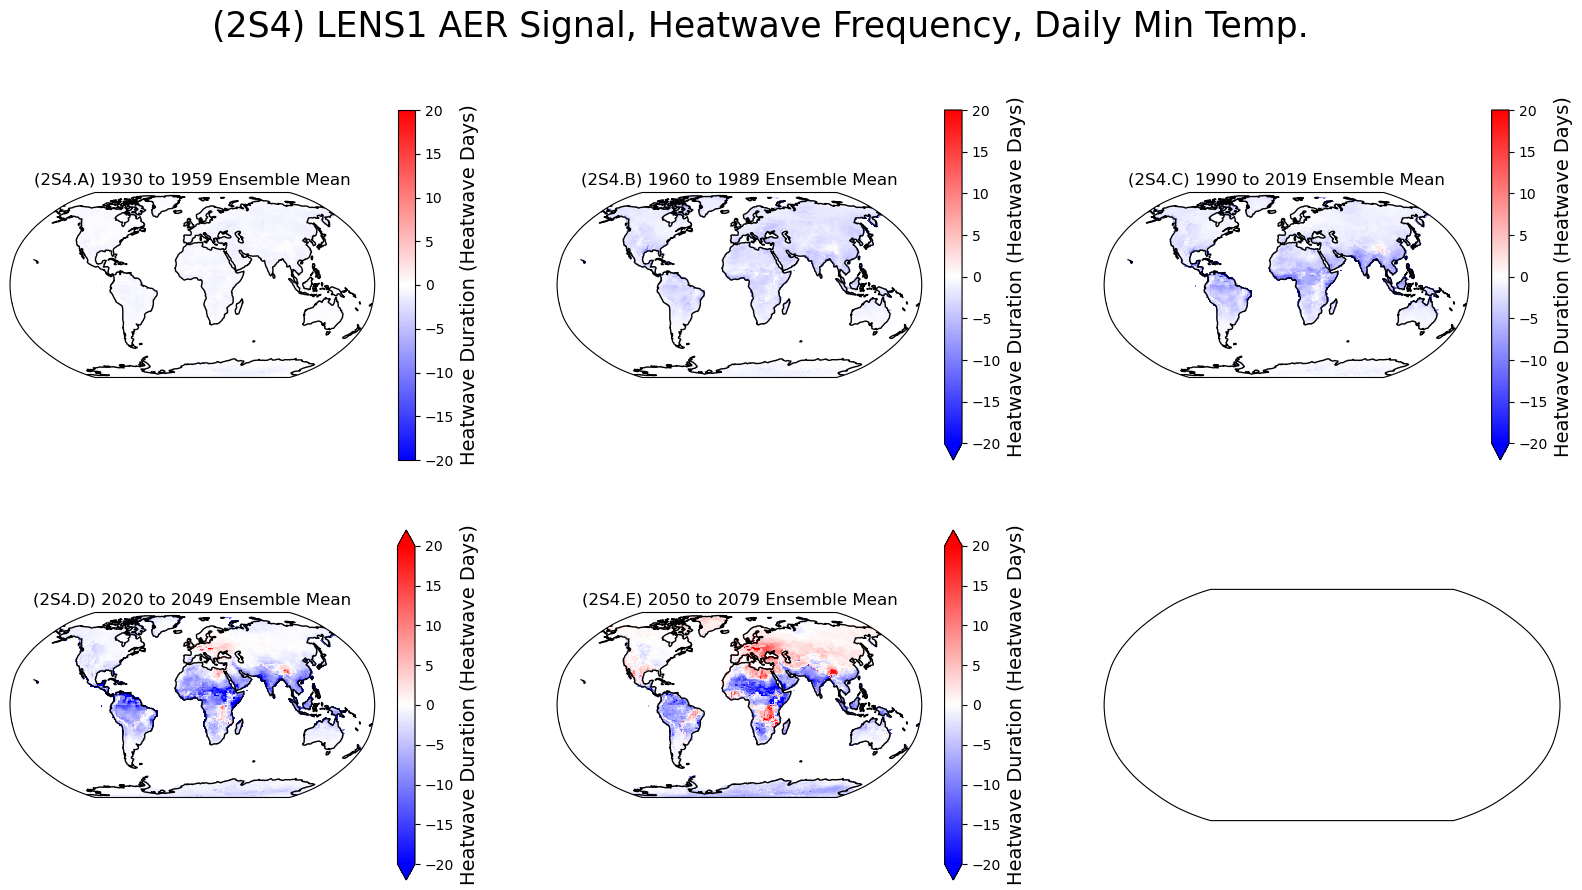

In [22]:
hw_mn_all = xarray.open_zarr(hw_mn_all_path)["HWD"]
hw_mn_xaer = xarray.open_zarr(hw_mn_xaer_path)["HWD"]

proj = ccrs.Robinson()
transform = ccrs.PlateCarree()

f1, axes1 = plt.subplots(2, 3, figsize=(20, 10), facecolor='w', subplot_kw=dict(projection=proj))
f2, axes2 = plt.subplots(2, 3, figsize=(20, 10), facecolor='w', subplot_kw=dict(projection=proj))

decades = [
    (1930, 1959),
    (1960, 1989),
    (1990, 2019),
    (2020, 2049),
    (2050, 2079)
]
label = ["A", "B", "C", "D", "E"]
for index, (start, end) in enumerate(decades):
    all_slice = hw_mn_all.sel(percentile=0.9).where(land_mask > 0).sel(year=slice(start, end)).mean(dim=["member", "year"]).compute()
    xaer_slice = hw_mn_xaer.sel(percentile=0.9).where(land_mask > 0).sel(year=slice(start, end)).mean(dim=["member", "year"]).compute()
    aer = all_slice - xaer_slice

    ax1 = axes1.flatten()[index]
    cb1 = all_slice.plot(ax=ax1, transform=transform, cmap="Reds", vmin=0, vmax=140)
    cb1.colorbar.set_label("Heatwave Duration (Heatwave Days)", fontsize=fz)
    ax1.coastlines()
    ax1.set_title(f"(2S3.{label[index]}) {start} to {end} Ensemble Mean")

    ax2 = axes2.flatten()[index]
    cb2 = aer.plot(ax=ax2, transform=transform, cmap="bwr", vmin=-20, vmax=20)
    cb2.colorbar.set_label("Heatwave Duration (Heatwave Days)", fontsize=fz)
    ax2.coastlines()
    ax2.set_title(f"(2S4.{label[index]}) {start} to {end} Ensemble Mean")


f1.suptitle("(2S3) LENS1 ALL-Forcing, Heatwave Frequency, Daily Min Temp.", fontsize=25)
f2.suptitle("(2S4) LENS1 AER Signal, Heatwave Frequency, Daily Min Temp.", fontsize=25)

f1.show()
f2.show()